In [113]:
import re # regular expressions!

# math and data utilities
import numpy as np
import pandas as pd

# data and statistics libraries
import sklearn.preprocessing as pre
from sklearn import model_selection
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Set-up default visualization parameters
mpl.rcParams['figure.figsize'] = [16,10]
viz_dict = {
    'figure.figsize':[16, 10],
    'axes.titlesize':18,
    'axes.labelsize':16,
}
sns.set_context("notebook", rc=viz_dict)
sns.set_style("whitegrid")

np.random.seed(723)

In [114]:
# Round 2: We already know random oversampling produced better results. Let's do it.

train_df = pd.read_csv('data/train.csv', index_col='PassengerId')
test_df = pd.read_csv('data/test.csv', index_col='PassengerId')

In [115]:
# Join training and test data for joint preprocessing:

survived = train_df.pop('Survived')
train_idx = train_df.index
test_idex = test_df.index
joint_df = pd.concat([train_df, test_df], axis=0)

del train_df, test_df


In [116]:
# begin feature engineering, same as last time:

joint_df['FamilySize'] = joint_df.Parch + joint_df.SibSp + 1
joint_df['Alone'] = joint_df.FamilySize.apply(lambda x: 1 if x==1 else 0)
joint_df['Title'] = joint_df.Name.str.extract(r'([A-Za-z]+)\.')
joint_df['NameLength'] = joint_df.Name.apply(len)

title_dict = {
    'Mrs': 'Mrs', 'Lady': 'Lady', 'Countess': 'Lady',
    'Jonkheer': 'Lord', 'Col': 'Officer', 'Rev': 'Officer',
    'Miss': 'Miss', 'Mlle': 'Miss', 'Mme': 'Miss', 'Ms': 'Miss', 'Dona': 'Lady',
    'Mr': 'Mr', 'Dr': 'Officer', 'Major': 'Officer', 'Capt': 'Officer', 'Sir': 'Lord', 'Don': 'Lord', 'Master': 'Master'
}

joint_df.Title = joint_df.Title.map(title_dict)

In [117]:
joint_df.head(10)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Alone,Title,NameLength
PassengerId,,,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,Mr,23
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0,Mrs,51
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,Miss,22
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,0,Mrs,44
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1,Mr,24
6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,1,1,Mr,16
7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,1,1,Mr,23
8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,5,0,Master,30
9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,3,0,Mrs,49


In [118]:
#Fill in missing age data with mean of passenger title agegroup:

for title in joint_df.Title.unique():
    mean_age = joint_df.loc[joint_df.Title == title, 'Age'].mean()
    joint_df.loc[(joint_df.Age.isnull() & (joint_df.Title == title)), 'Age'] = mean_age
    print(f'Title: {title}, Avg Age: {mean_age}')

joint_df.Age.isnull().value_counts()

Title: Mr, Avg Age: 32.25215146299484
Title: Mrs, Avg Age: 36.99411764705882
Title: Miss, Avg Age: 21.834532710280374
Title: Master, Avg Age: 5.482641509433963
Title: Lord, Avg Age: 42.333333333333336
Title: Officer, Avg Age: 46.27272727272727
Title: Lady, Avg Age: 40.0


False    1309
Name: Age, dtype: int64

In [119]:
# Let's get new information:

joint_df

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Alone,Title,NameLength
PassengerId,,,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,2,0,Mr,23
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,2,0,Mrs,51
3,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,Miss,22
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,2,0,Mrs,44
5,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,1,1,Mr,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,3,"Spector, Mr. Woolf",male,32.252151,0,0,A.5. 3236,8.0500,NaN,S,1,1,Mr,18
1306,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,C,1,1,Lady,28
1307,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,1,1,Mr,28


In [120]:
joint_df['Deck'] = joint_df.Cabin.str.extract(r'([ABCDEFG])')

,Deck,Pclass
PassengerId,,
2,C,1
4,C,1
7,E,1
11,G,3
12,C,1
...,...,...
1296,D,1
1297,D,2
1299,C,1


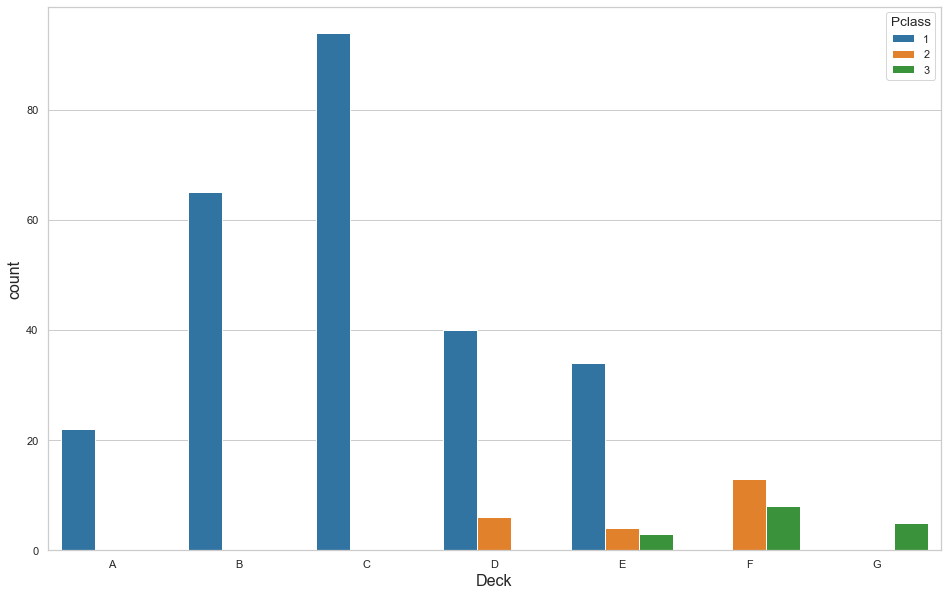

In [121]:
df = joint_df[['Deck', 'Pclass']][joint_df.Deck.notnull()]
df2 = joint_df.loc[:, ['Deck', 'Pclass']][joint_df.Deck.notnull()]
df = df.sort_values(by=['Deck'])
sns.countplot(x='Deck', hue='Pclass', data=df)
df2

In [122]:
# Looks we can map 1st class to C deck, 2nd class to F deck and 3rd class to F as well

joint_df.Pclass.value_counts()
joint_df.Deck.isnull().value_counts()

True     1015
False     294
Name: Deck, dtype: int64

In [123]:
joint_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      1309 non-null   int64  
 1   Name        1309 non-null   object 
 2   Sex         1309 non-null   object 
 3   Age         1309 non-null   float64
 4   SibSp       1309 non-null   int64  
 5   Parch       1309 non-null   int64  
 6   Ticket      1309 non-null   object 
 7   Fare        1308 non-null   float64
 8   Cabin       295 non-null    object 
 9   Embarked    1307 non-null   object 
 10  FamilySize  1309 non-null   int64  
 11  Alone       1309 non-null   int64  
 12  Title       1309 non-null   object 
 13  NameLength  1309 non-null   int64  
 14  Deck        294 non-null    object 
dtypes: float64(2), int64(6), object(7)
memory usage: 163.6+ KB


In [124]:
joint_df.loc[joint_df.Pclass == 3 & joint_df.Deck.isnull()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68 entries, 31 to 1295
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      68 non-null     int64  
 1   Name        68 non-null     object 
 2   Sex         68 non-null     object 
 3   Age         68 non-null     float64
 4   SibSp       68 non-null     int64  
 5   Parch       68 non-null     int64  
 6   Ticket      68 non-null     object 
 7   Fare        68 non-null     float64
 8   Cabin       1 non-null      object 
 9   Embarked    68 non-null     object 
 10  FamilySize  68 non-null     int64  
 11  Alone       68 non-null     int64  
 12  Title       68 non-null     object 
 13  NameLength  68 non-null     int64  
 14  Deck        0 non-null      object 
dtypes: float64(2), int64(6), object(7)
memory usage: 8.5+ KB


### however we see that the majority of passengers were actually 3rd class. Looking at the graph, we see that data on 3rd class (and 2nd to some extent) decks is extremely under-represented. This gives me less confidence in just assigning all missing cabin data for 3rd class to cabin F. I think I'll make a random assignment between E, F F and G instead. 



In [125]:
# rough estimate of weights based on graph:
choice_dict = {
    1: [['A', 'B', 'C', 'D', 'E'],
        [.12, .22, .32, .20, .14]],
    2: [['D', 'E', 'F'], 
        [.16, .34, .50]],
    3: [['E', 'F', 'G'],
        [1/3, 1/3, 1/3]]
}

for key, value in choice_dict.items():  
    m = (joint_df.Pclass == key) & joint_df.Deck.isnull()
    num = len(joint_df.loc[m, 'Deck'])
    fill_in = np.random.choice(value[0], size=num, p=value[1])
    joint_df.loc[m, 'Deck'] = fill_in
    

In [126]:
joint_df.Deck.value_counts()

F    398
E    347
G    233
C    114
D    110
B     80
A     27
Name: Deck, dtype: int64

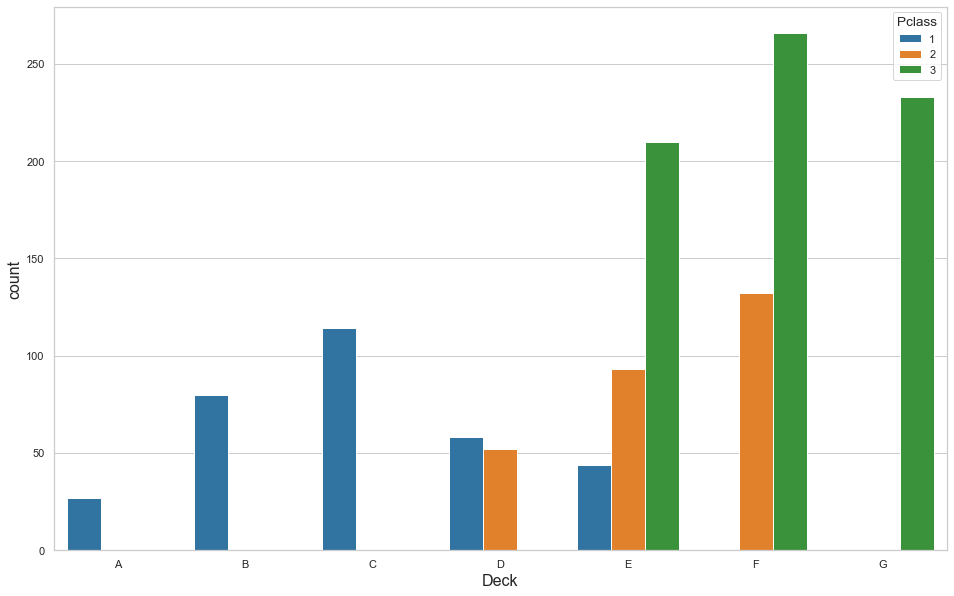

In [127]:
sns.countplot(x='Deck', hue='Pclass', data=joint_df.sort_values(by='Deck'))

In [128]:
joint_df.head(3)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Alone,Title,NameLength,Deck
PassengerId,,,,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,Mr,23,F
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0,Mrs,51,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,Miss,22,F


In [129]:
joint_df.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [130]:
joint_df['Sex'], int2class_sex = pd.factorize(joint_df.Sex)
joint_df['Title'], int2class_title = pd.factorize(joint_df.Title)
joint_df['Embarked'], int2class_embarked = pd.factorize(joint_df.Embarked)
joint_df['Deck'], int2class_deck = pd.factorize(joint_df.Deck)

# To get the categorical data back, simply use the following:
int2class_sex.take(joint_df.Sex)

Index(['male', 'female', 'female', 'female', 'male', 'male', 'male', 'male',
       'female', 'female',
       ...
       'female', 'female', 'female', 'female', 'female', 'male', 'female',
       'male', 'male', 'male'],
      dtype='object', length=1309)

In [131]:
categorical_features = ['Pclass', 'Sex', 'Alone', 'Title', 'Embarked', 'Deck']
continuous_features = ['Fare', 'Age', 'NameLength']

# to_scale = joint_df[continuous_features]
# scaled_cols = pre.scale(to_scale)
joint_df[continuous_features] = scaled_cols

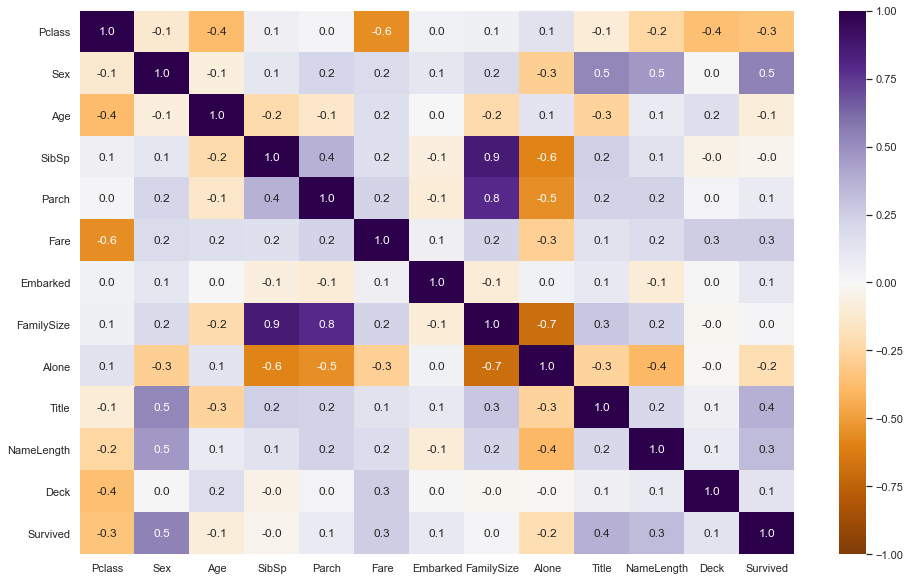

In [132]:
sns.heatmap(pd.concat([joint_df, survived], axis = 1).corr(), vmin=-1, vmax=1, cmap="PuOr", annot=True, fmt='0.1f')
plt.grid(None)

In [133]:
#ROS
joint_df.drop(['Deck'], axis=1)
train_df = joint_df.loc[train_idx,:]
test_df = joint_df.loc[test_idex, :]
train_df['Survived'] = survived

In [134]:
died_count, lived_count = train_df.Survived.value_counts()

In [135]:
died_df = train_df[train_df.Survived == 0]
lived_df = train_df[train_df.Survived == 1]

lived_os_df = lived_df.sample(died_count, replace=True)


In [136]:
train_os_df = pd.concat([died_df, lived_os_df], axis = 0)

In [137]:
X = train_os_df.drop(['Survived'], axis = 1)
Y = train_os_df.Survived
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=.25)

train_os_df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Alone,Title,NameLength,Deck,Survived
PassengerId,,,,,,,,,,,,,
1,3,0,-0.598610,1,0,-0.503402,0,2,0,0,-0.434672,0,0
5,3,0,0.386875,0,0,-0.487940,0,1,1,0,-0.329441,2,0
6,3,0,0.178570,0,0,-0.480049,2,1,1,0,-1.171292,3,0
7,1,0,1.827199,0,0,0.358860,0,1,1,0,-0.434672,2,0
8,3,0,-2.114740,3,1,-0.236195,0,5,0,3,0.301947,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,2,1,0.159455,0,0,-0.392267,0,1,1,1,-0.855598,0,1
413,1,1,0.235262,1,0,1.095975,2,2,0,2,-0.539904,1,1
450,1,0,1.675585,0,0,-0.054031,0,1,1,5,0.301947,1,1


In [138]:
classifier = LogisticRegression()
classifier.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [139]:
# a function to pretty print our dictionary of dictionaries:
def pprint(web, level):
    for k,v in web.items():
        if isinstance(v, dict):
            print('\t'*level, f'{k}: ')
            level += 1
            pprint(v, level)
            level -= 1
        else:
            print('\t'*level, k, ": ", v)

In [140]:
y_pred = classifier.predict(x_test)

In [141]:
eval = metrics.classification_report(y_test, y_pred, 
                                              labels=[0,1], 
                                              target_names=['Died', 'Survived'],
                                              output_dict=True)

In [142]:
pprint(eval, 0)

 Died: 
	 precision :  0.796875
	 recall :  0.7846153846153846
	 f1-score :  0.7906976744186046
	 support :  130
 Survived: 
	 precision :  0.8095238095238095
	 recall :  0.8206896551724138
	 f1-score :  0.8150684931506851
	 support :  145
 accuracy :  0.8036363636363636
 macro avg: 
	 precision :  0.8031994047619048
	 recall :  0.8026525198938992
	 f1-score :  0.8028830837846448
	 support :  275
 weighted avg: 
	 precision :  0.8035443722943723
	 recall :  0.8036363636363636
	 f1-score :  0.803547742477338
	 support :  275
